In [259]:
import bs4 as bs
import pickle
import requests
import datetime as dt
import os
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from math import sqrt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import style
%matplotlib inline
style.use('ggplot')

In [157]:
tres = pd.read_csv('5-year-treasury-bond-rate-yield-chart.csv')

In [158]:
tres = tres.drop(columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6'])

In [159]:
tres['date'] = pd.to_datetime(tres['date'])
tres = tres.set_index('date')

In [172]:
risk_free_rate = float(tres['2000':'2019'].mean())/100

In [174]:
df = pd.read_csv('companies.csv')
df = df['symbol'].unique()
tickers = df.tolist()
Y = []
ticks = pd.DataFrame(tickers)
for tickers in tickers:
    try:
        df = pd.read_csv('stock_dfs/{}.csv'.format(tickers))
        df['avg_yr_returns'] = df['Adj Close'].pct_change().mean() * 252
        df['yr_variance'] = df['Adj Close'].pct_change().std() * sqrt(252)
        df = df.drop(['Open', 'High', 'Low', 'Close','Volume','Date', 'Adj Close'], 1)
        df = df.tail(1)
        df['sharpe_ratio'] = df.avg_yr_returns - risk_free_rate/df.yr_variance
        Y.append(df)
    except:
        print(f'{tickers} not found')
    
df = pd.concat(Y, sort = False)
df = df.reset_index()
kclus_ = df.merge(ticks, left_index = True, right_index = True)
kclus_= kclus_.rename({0: 'symbol'}, axis = 1)
kclus_ = kclus_.set_index('symbol')

ARRS not found
WIN not found


In [175]:
kclus = kclus_.drop(columns = 'index')

In [192]:
kclus = kclus.reset_index()

In [193]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

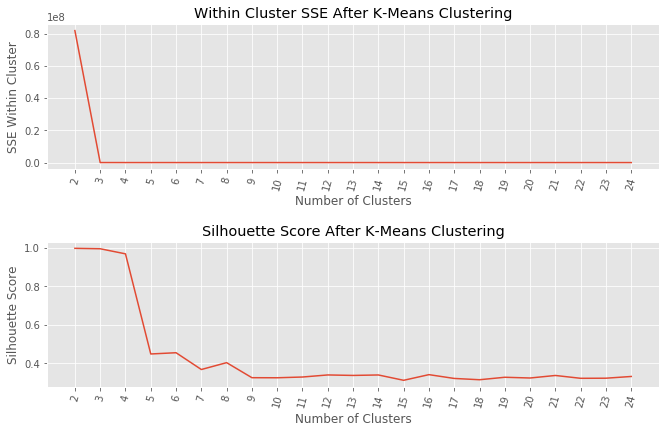

In [194]:
plot_cluster(kclus, max_loop=25)

In [195]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("SSE withing cluster: " + str(sse_within_cluster.round()))
    
    return df

In [226]:
first_trial = apply_cluster(kclus, clusters = 8)

clustering performance
-----------------------------------
silhouette score: 0.4
SSE withing cluster: 681.0


In [227]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yr_returns":"mean", "yr_variance":"mean", "sharpe_ratio": "mean", "symbol":"count"})
    .sort_values('avg_yr_returns')
    .reset_index()
)

cluster_perf_df

,cluster,avg_yr_returns,yr_variance,sharpe_ratio,symbol
0,7,-0.261225,0.512625,-0.322774,8
1,0,0.124444,0.334109,0.035266,352
2,5,0.230948,0.447072,0.164471,196
3,6,0.798425,1.067410,0.768229,4
4,4,2.855372,7.676892,2.851736,1
5,3,4.943280,8.272611,4.939905,1
6,2,1332.564451,3977.384145,1332.564444,1
7,1,1672.470956,2257.880274,1672.470943,1


In [201]:
cluster_perf_df[cluster_perf_df['cluster'] == 1]

,cluster,avg_yr_returns,yr_variance,sharpe_ratio,symbol
7,1,1672.470956,2257.880274,1672.470943,1


In [228]:
second_trial = apply_cluster(kclus, clusters = 7)

clustering performance
-----------------------------------
silhouette score: 0.37
SSE withing cluster: 962.0


In [229]:
cluster_perf_df2 = (
    second_trial
    .groupby('cluster')
    .agg({"avg_yr_returns":"mean", "yr_variance":"mean", "sharpe_ratio": "mean", "symbol":"count"})
    .sort_values('avg_yr_returns')
    .reset_index()
)

cluster_perf_df2

,cluster,avg_yr_returns,yr_variance,sharpe_ratio,symbol
0,4,0.108721,0.341800,0.020576,329
1,0,0.225598,0.426789,0.155498,227
2,6,0.798425,1.067410,0.768229,4
3,5,2.855372,7.676892,2.851736,1
4,3,4.943280,8.272611,4.939905,1
5,1,1332.564451,3977.384145,1332.564444,1
6,2,1672.470956,2257.880274,1672.470943,1


In [230]:
third_trial = apply_cluster(kclus, clusters = 5)

clustering performance
-----------------------------------
silhouette score: 0.45
SSE withing cluster: 1884.0


In [231]:
cluster_perf_df3 = (
    third_trial
    .groupby('cluster')
    .agg({"avg_yr_returns":"mean", "yr_variance":"mean", "sharpe_ratio": "mean", "symbol":"count"})
    .sort_values('avg_yr_returns')
    .reset_index()
)

cluster_perf_df3

,cluster,avg_yr_returns,yr_variance,sharpe_ratio,symbol
0,0,0.128621,0.351314,0.043045,439
1,4,0.278587,0.490713,0.216892,121
2,3,3.899326,7.974751,3.895820,2
3,1,1332.564451,3977.384145,1332.564444,1
4,2,1672.470956,2257.880274,1672.470943,1


In [232]:
fourth_trial = apply_cluster(kclus, clusters = 6)

clustering performance
-----------------------------------
silhouette score: 0.46
SSE withing cluster: 1347.0


In [233]:
cluster_perf_df4 = (
    fourth_trial
    .groupby('cluster')
    .agg({"avg_yr_returns":"mean", "yr_variance":"mean", "sharpe_ratio": "mean", "symbol":"count"})
    .sort_values('avg_yr_returns')
    .reset_index()
)

cluster_perf_df4

,cluster,avg_yr_returns,yr_variance,sharpe_ratio,symbol
0,0,0.129819,0.353383,0.044668,447
1,4,0.284467,0.492398,0.222778,113
2,5,2.855372,7.676892,2.851736,1
3,3,4.943280,8.272611,4.939905,1
4,2,1332.564451,3977.384145,1332.564444,1
5,1,1672.470956,2257.880274,1672.470943,1


In [247]:
fifth_trial = apply_cluster(kclus, clusters = 14)

clustering performance
-----------------------------------
silhouette score: 0.34
SSE withing cluster: 251.0


In [248]:
cluster_perf_df5 = (
    fifth_trial
    .groupby('cluster')
    .agg({"avg_yr_returns":"mean", "yr_variance":"mean", "sharpe_ratio": "mean", "symbol":"count"})
    .sort_values('avg_yr_returns')
    .reset_index()
)

cluster_perf_df5 

,cluster,avg_yr_returns,yr_variance,sharpe_ratio,symbol
0,9,-0.285280,0.535162,-0.344384,7
1,12,0.016662,0.420151,-0.054211,29
2,6,0.098306,0.393493,0.026395,67
3,11,0.114748,0.247482,0.000041,94
4,7,0.165918,0.523576,0.111476,77
5,0,0.167649,0.325985,0.080049,169
6,10,0.242668,0.370960,0.165464,79
7,4,0.305173,0.561448,0.253746,31
8,13,0.500286,0.546046,0.448748,4
9,8,0.858071,1.247878,0.835502,3


In [375]:
df = pd.read_csv('companies.csv')
df = df['symbol'].unique()
new_df = pd.read_csv('tickers_new.csv')
new_df = new_df.set_index('ticker')
tickers = df.tolist()
Y = []
ticks = pd.DataFrame(tickers)
for tickers in tickers:
    try:
        df = pd.read_csv('stock_dfs/{}.csv'.format(tickers))
        df = df.drop(['Open', 'High', 'Low', 'Close','Volume','Date'], 1)
        df = df.tail(1)
        Y.append(df)
    except:
        print(f'{tickers} not found')
    
df = pd.concat(Y, sort = False)
df = df.reset_index()
df_ = df.merge(ticks, left_index = True, right_index = True)
df_= df_.rename({0: 'symbol','Adj Close': 'Price'}, axis = 1)
df_ = df_.set_index('symbol')
df_ = df_.drop(columns = 'index')
df_ = df_.merge(new_df, left_index = True, right_index = True)
df_ = df_.reset_index()

ARRS not found
WIN not found


In [380]:
clusters_rec = kclus.merge(df_, left_index= True, right_index = True)

In [387]:
clusters_rec = clusters_rec.drop(columns = 'index')

In [389]:
clusters_rec.to_csv('/Users/flatironschool/UrPortfolio/recommendation_system/clusters_rec.csv')